In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from util import Logger

# Discriminator
According to the paper, the discriminator has the following architecture.  
![Discriminator](Images/Discriminator.jpg)  
I designed the above picture using [alexlenail.me](http://alexlenail.me/NN-SVG/AlexNet.html).  
This architecture, however, has minor differences compared to the original diagram shown in the article. To begin with, it is apparent that instead of a 5x5 filter, here is 4x4. The reason is because of the following formula:
$$n_{out} = \lfloor\frac{n_{in} + 2p - k}{s}\rfloor + 1$$
$where$  
$n_{in}$ : **number of input features**  
$n_{out}$: **number of output features**  
$k$: **convolution kernel size**  
$p$: **convolution padding size**  
$s$: **convolution stride size**  
As we see from the formula, if $n_{in} = 64$, $p = 1$, $k = 4$ and $s = 1$, then $n_{out} = 32$; however, the calculation is not right if we set $k = 5$ without padding.

The order is also inverted from the original architecture, which is a noteworthy change. This is due to the fact that the paper's illustrated architecture was intended for the generator. Last but not least, we have 1-dimensional output at the result of this network since we need to evaluate whether the provided input picture is fake or not.

There are other points that are important to be mentioned which cannot be inferred from the picture above:
* Batchnorm is used for all layers
* LeakyReLU activation is used for all layers with 0.2 as the slope of the leak
* Since applying batchnorm to all layers cause sample oscillation and model instability, the paper suggested to avoid using batchnorm in the discriminator input layer.
* the last convolution layer is flattened and then fed into a single sigmoid output.
* Replace any pooling layers with strided convolutions.

In [2]:
class Discriminator(nn.Module):
    def __init__(self, image_channel_numbers=3, feature_depth=128):
        super(Discriminator, self).__init__()
        
        self.leaky_relu_negative_slope = 0.2
        self.discriminator = nn.Sequential(
            self.input_conv_block(in_channels=image_channel_numbers, out_channels=feature_depth),  #  3x64x64 -> 128x32x32
            self.conv_block(in_channels=feature_depth, out_channels=feature_depth * 2),   #  128x32x32 -> 256x16x16
            self.conv_block(in_channels=feature_depth * 2, out_channels=feature_depth * 4),   #  256x16x16 -> 512x8x8
            self.conv_block(in_channels=feature_depth * 4, out_channels=feature_depth * 8),   #  512x8x8 -> 1024x4x4
            self.conv_block(in_channels=feature_depth * 8, out_channels=1, padding=0),   #  1024x4x4 -> 1x1x1
            nn.Sigmoid(),
        )
    
    def input_conv_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size=4,
                      stride=2,
                      padding=1),
            nn.LeakyReLU(self.leaky_relu_negative_slope)
        )
    
    def conv_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding,
                      bias=False,  # Since we use batchnorm, it is not necessary to use bias
                     ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(self.leaky_relu_negative_slope)
        )
    
    def forward(self, x):
        return self.discriminator(x)

# Generator
![Generator](Images/Generator.jpg)

In addition to the architecture described above, there are a few points described in the paper:
* Batchnorm is used for all layers
* For the same reason as discriminator, batchnorm is not used in generator but in output layer.
* ReLU activation is used for all layers except for output, which uses Tanh.
* Replace any pooling layers with fractional-strided convolutions.

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dimension, image_channel_numbers=3, features_depth=64):
        super(Generator, self).__init__()
        
        self.generator = nn.Sequential(
            self.conv_block(z_dimension, features_depth * 16, padding=0), #  1xz_dimensionx1 -> 1024x4x4
            self.conv_block(features_depth * 16, features_depth * 8),   #  1024x4x4 -> 512x8x8
            self.conv_block(features_depth * 8, features_depth * 4),   #  512x8x8 -> 256x16x16
            self.conv_block(features_depth * 4, features_depth * 2),   #  256x16x16 -> 128x32x32
            self.output_conv_block(features_depth * 2, image_channel_numbers)   #  128x32x32 -> 3x64x64
            
        )
        
    def conv_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding,
                      bias=False,  # Since we use batchnorm, it is not necessary to use bias
                     ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def output_conv_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,
                      out_channels,
                      kernel_size=4,
                      stride=2,
                      padding=1),
            nn.Tanh()  # Make the ouput to be [-1, 1]
        )
    
    def forward(self, x):
        return self.generator(x)

# Weight initialization
Based on the paper we have **"All weights were initialized from a zero-centered Normal distribution
with standard deviation 0.02"**. So let's do that.

In [4]:
def weight_initialization(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(module.weight.data, mean=0, std=0.02)   # we use normal_ instead of normal so that the opration
                                                               # would be inplace.

# Test
Now we need to test to check the dimensions and ensure that the computation is correct.

In [5]:
def test():
    sample_numbers, in_channels, width, height = 8, 3, 64, 64
    z_dimension = 100
    x = torch.randn((sample_numbers, in_channels, width, height))
    z = torch.randn((sample_numbers, z_dimension, 1, 1))
    
    discriminator = Discriminator(in_channels)
    weight_initialization(discriminator)
    assert discriminator(x).shape == (sample_numbers, 1, 1, 1)
    print("Discriminator shape is correct.")
    
    generator = Generator(z_dimension)
    assert generator(z).shape == (sample_numbers, in_channels, width, height)
    print("Generator shape is correct.")

In [6]:
test()

Discriminator shape is correct.
Generator shape is correct.


# Hyperparameters

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 0.0002   # From the paper
BATCH_SIZE = 128   # From the paper
IMAGE_SIZE = 64
NUMBER_OF_IMAGE_CHANNELS = 3
Z_DIMENSION = 100   #  From the paper
NUM_EPOCHS = 5

# Transforms
Before loading images, we have to:
* `Resize` image to the `IMAGE_SIZE` defined above.
* Call `ToTensor()` to convert values of each channel [0, 255] to [0, 1].
* Call Normalize to convert [0, 1] values to [-1, 1]. This is because we use `nn.Tanh()` as the activation function of the last layer of the generator.

**Elaborating the third point:** `transforms.Normalize()` does the following for each channel:
$$image\_value=\frac{image\_value - mean}{std}$$  
So by passing 0.5 as mean and std, the maximum value would be $\frac{(1 - 0.5)}{0.5}=1$ and the minimum value would be $\frac{(0 - 0.5)}{0.5}=-1$

In [8]:
transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(NUMBER_OF_IMAGE_CHANNELS)],
            [0.5 for _ in range(NUMBER_OF_IMAGE_CHANNELS)],
        )
    ]
)

# Initiate the models

In [9]:
# dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms, download=True)
dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

generator = Generator(Z_DIMENSION, NUMBER_OF_IMAGE_CHANNELS).to(device)
discriminator = Discriminator(NUMBER_OF_IMAGE_CHANNELS).to(device)

weight_initialization(generator)
weight_initialization(discriminator)

# Optimizer and criterion
Based on the paper, to stabilize training, the authors suggest using 0.5 for the $\beta_{1}$, and we set $\beta_{2}$ to its default value.

In [10]:
generator_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

We set a `fixed_noise` so as to evaluate the progress of our models

In [11]:
num_test_samples = 32
fixed_noise = torch.randn(num_test_samples, Z_DIMENSION, 1, 1).to(device)

Set both of networks to training mode. this should be by default

In [12]:
generator.train()
discriminator.train();

# Training Discriminator
Discriminator has the following loss function:
$$\frac{1}{m} \sum_{i=1}^{m} [logD(x^{(i)})+log(1-D(G(z^{i})))]$$
$where$  
$m$ : **number of training examples**  
$x^{(i)}$: **real data**  
$z^{i}$: **fake data**  
$D$: **Discriminator function**  
$G$: **Generator function**  
As we know, we want the discriminator to detect the actual image as the real one ($D(x^{(i)})=1$), and we want the output of the generator, which is $G(z^{i})$ to be detected as the fake one ($D(G(z^{i}))=0$).  
Putting the desired value in the loss function, we get zero since $log(1)=0$.

Now the question is, does the discriminator want to **maximize** or **minimize** this?
![Log](Images/log.png)
Based on the log function above, the more we stay away from the $log(1)$, the more negative value the result will be. Therefore, we want to **maximize** this loss function.

In [13]:
def train_discriminator(optimizer, real_data, fake_data):
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data).reshape(-1)
    # Calculate error and backpropagate
    error_real = criterion(prediction_real, torch.ones_like(prediction_real))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data).reshape(-1)
    # Calculate error and backpropagate
    error_fake = criterion(prediction_fake, torch.zeros_like(prediction_fake))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

# Training Generator
Generator has the following loss function:
$$\frac{1}{m} \sum_{i=1}^{m} log(1-D(G(z^{i})))$$

The generator's goal is to deceive the discriminator, thus $D(G(z^{i}))$ should be one, and log(0) should be near to $-\infty$. As a result, the generator wants to **minimize** the loss function. However, the above loss function has weak gradients and in practice, the generator tries to maximize $logD(G(z^{i}))$ instead.

In [14]:
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Sample noise and generate fake data
    prediction = discriminator(fake_data).reshape(-1)

    # Calculate error and backpropagate
    error = criterion(prediction, torch.ones_like(prediction))
    error.backward()

    # Update weights with gradients
    optimizer.step()

    return error

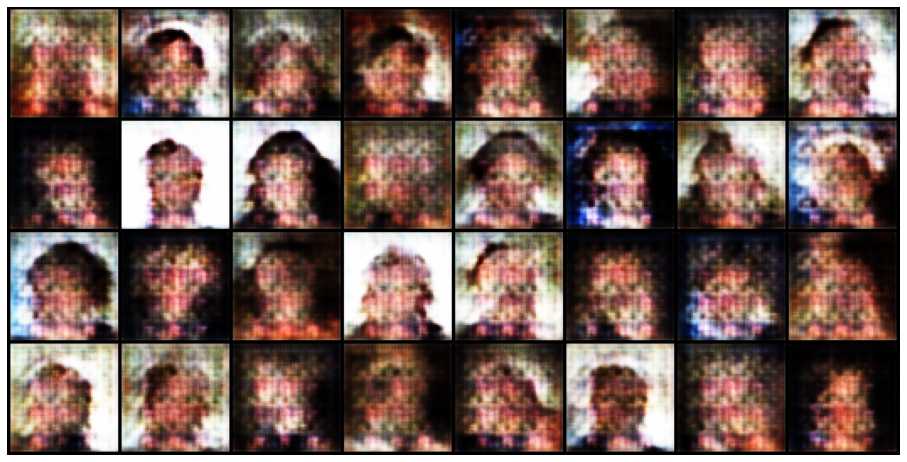

Epoch: [1/5], Batch Num: [1583/1583]
Discriminator Loss: 1.3864, Generator Loss: 0.6973
D(x): 0.4985, D(G(z)): 0.4985


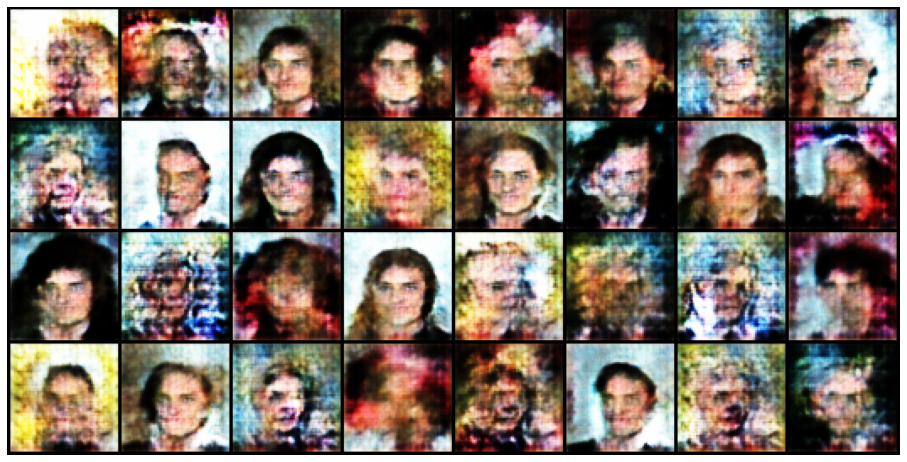

Epoch: [2/5], Batch Num: [1583/1583]
Discriminator Loss: 1.3868, Generator Loss: 0.6907
D(x): 0.5041, D(G(z)): 0.5039


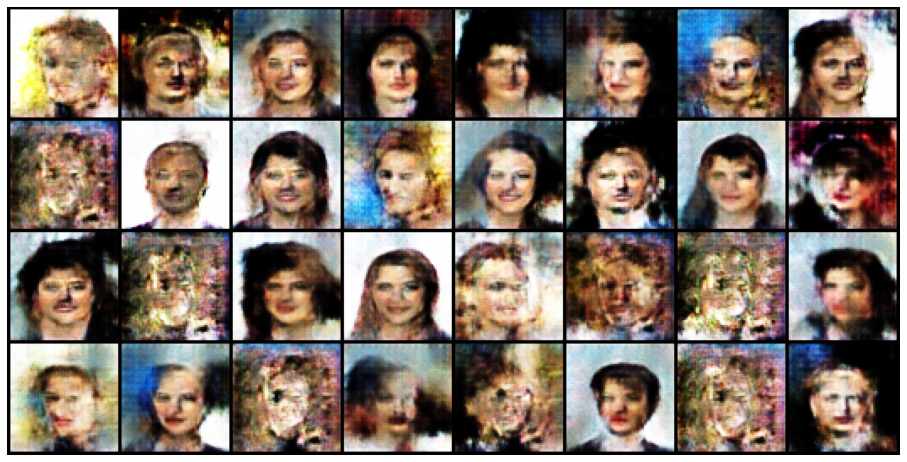

Epoch: [3/5], Batch Num: [1583/1583]
Discriminator Loss: 1.3771, Generator Loss: 0.6916
D(x): 0.5090, D(G(z)): 0.5034


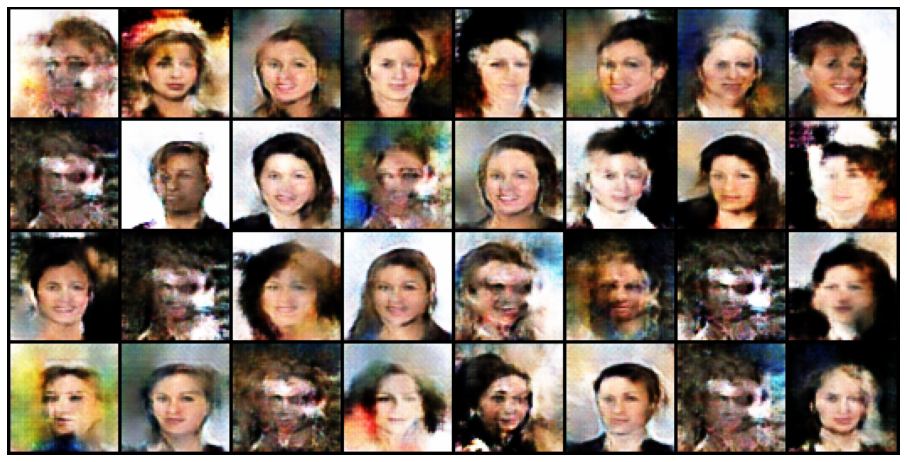

Epoch: [4/5], Batch Num: [1583/1583]
Discriminator Loss: 1.3530, Generator Loss: 0.6883
D(x): 0.5293, D(G(z)): 0.5059


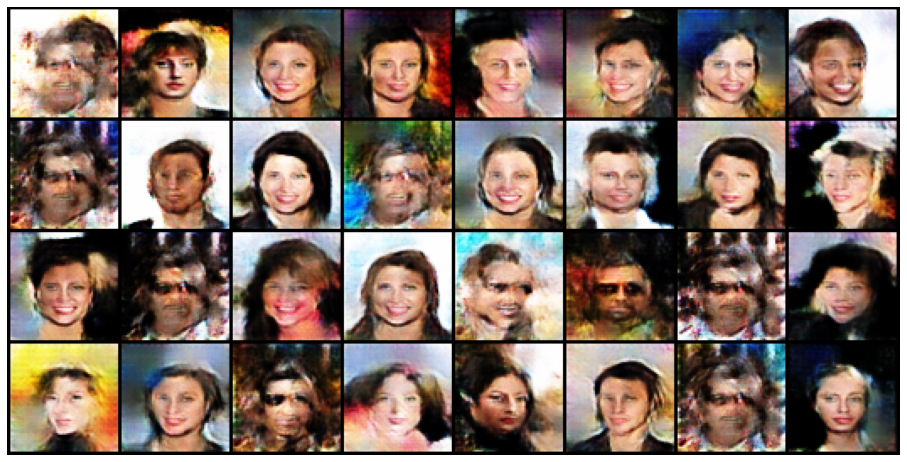

Epoch: [5/5], Batch Num: [1583/1583]
Discriminator Loss: 1.3357, Generator Loss: 0.6895
D(x): 0.5383, D(G(z)): 0.5033


In [15]:
logger = Logger(model_name='DCGANs', data_name='MNIST')

batch_numbers = len(loader)
for epoch in range(NUM_EPOCHS):
    for batch_idx, (data, _) in enumerate(loader):
        # Train Discriminator        
        real_data = data.to(device=device)
        
        noise = torch.randn(BATCH_SIZE, Z_DIMENSION, 1, 1).to(device=device)
        fake_data = generator(noise).detach()
        fake_data = fake_data.to(device=device)
        
        d_error, d_pred_real, d_pred_fake = train_discriminator(discriminator_optimizer, real_data, fake_data)
        
        # Train Generator
        noise = torch.randn(BATCH_SIZE, Z_DIMENSION, 1, 1).to(device=device)
        fake_data = generator(noise)
        
        g_error = train_generator(generator_optimizer, fake_data)
        
        logger.log(d_error, g_error, epoch, batch_idx, BATCH_SIZE)
        
        if batch_idx == batch_numbers - 1:
            with torch.no_grad():
                test_images = generator(fixed_noise).cpu()

                logger.log_images(
                    test_images, num_test_samples, 
                    epoch + 1, batch_idx + 1, batch_numbers
                );

                # Display status Logs
                logger.display_status(
                    epoch + 1, NUM_EPOCHS, batch_idx + 1, batch_numbers,
                    d_error, g_error, d_pred_real, d_pred_fake
                )